In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import datetime as dt
import math as mt
from pymongo import MongoClient as mc
import IPython
import IPython.display
from sklearn.decomposition import TruncatedSVD 
from scipy.spatial import distance
import scipy.stats
from modules.models import *
from modules.utils import *
import modules.new_utils as nu
from tqdm import trange

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 1. read datas.xlsx
xlsx = load_excel("datas/datas.xlsx")

In [4]:
# 2. data pre-processing
p, m = data_preprocessing(xlsx)

/Users/formegusto/Desktop/idoformegusto/development/research/contract-recommendation-system/prototype/notebook/modules/utils/data_preprocessing.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  datas_df[household_name] = household_df[col][3:].to_list()
/Users/formegusto/Desktop/idoformegusto/development/research/contract-recommendation-system/prototype/notebook/modules/utils/data_preprocessing.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  month_usage_df[name] = [


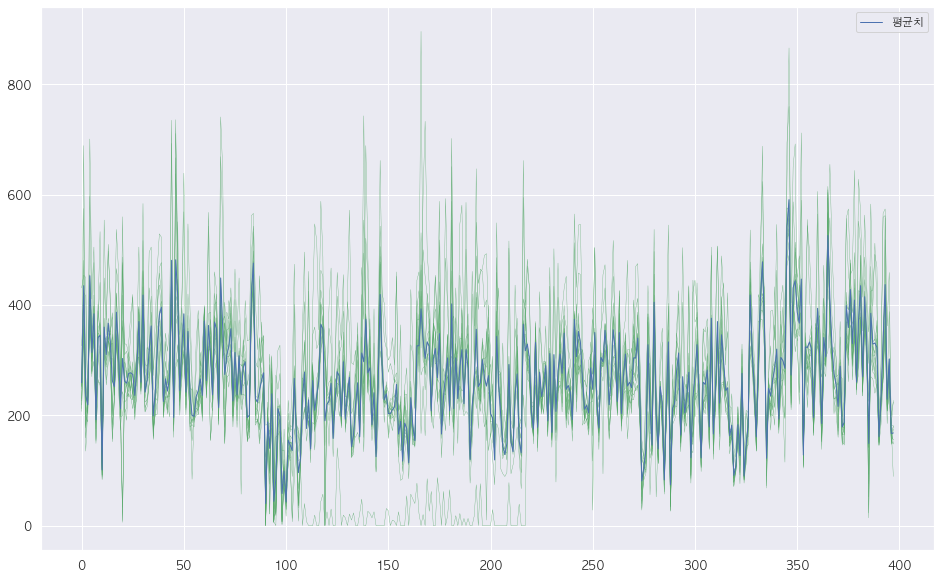

In [60]:
test = m.set_index("month").copy()
test.loc['mean'] = test.mean(axis=0).round()
test_np = np.array(test)
plt.figure(figsize=(16,10))
for idx, value in enumerate(test_np):
    plt.plot(value, linewidth=0.3, color='g')
    if idx == 12:
        plt.plot(value, linewidth=1, color='b', label="평균치")

plt.legend()

<AxesSubplot:>

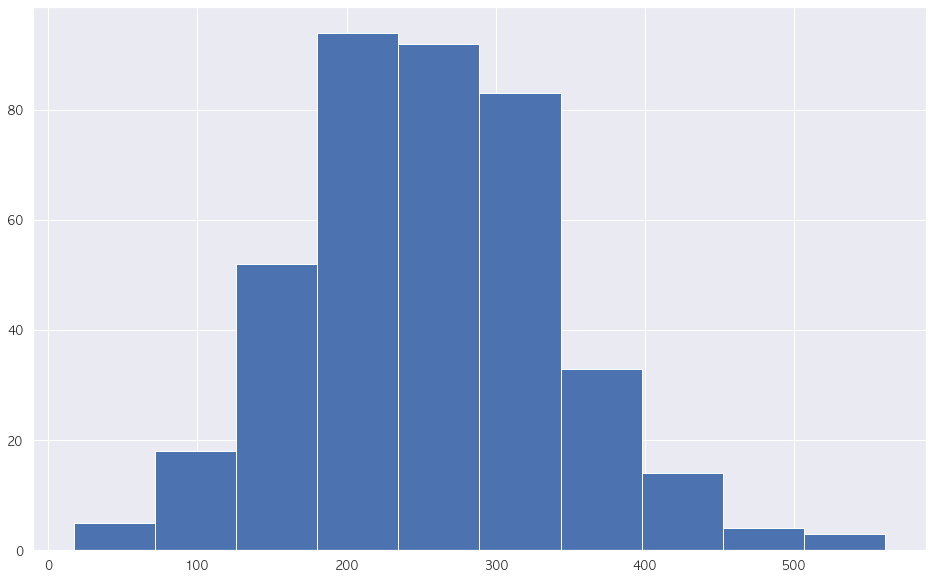

In [211]:
plt.figure(figsize=(16, 10))
test.loc['sim'].hist()

In [5]:
p

,month,peak (kW)
0,1,224.0
1,2,224.0
2,3,212.0
3,4,208.0
4,5,152.0
5,6,200.0
6,7,356.0
7,8,356.0
8,9,204.0
9,10,192.0


In [153]:
m.set_index("month")

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,335,363,181,216,270,518,230,279,161,156
2,251,481,177,218,397,297,339,197,348,288,...,309,339,146,184,267,344,208,236,167,150
3,255,424,203,222,378,303,349,202,357,368,...,313,372,152,236,268,417,212,272,166,155
4,252,355,180,230,368,278,298,188,346,365,...,266,346,149,210,268,421,208,243,156,148
5,230,357,258,203,414,270,418,156,320,265,...,305,256,151,222,287,349,185,284,165,180
6,212,363,272,207,411,275,398,149,265,254,...,240,257,145,212,353,413,212,292,153,148
7,326,423,416,204,597,350,477,210,374,441,...,492,469,179,294,566,574,362,459,181,227
8,431,454,450,207,701,411,505,236,385,533,...,512,394,177,283,559,562,245,388,199,224
9,207,334,198,188,445,299,369,153,261,258,...,274,242,146,233,328,371,207,278,182,181


In [18]:
# 3. bill - calc
min_per = 10
max_per = 80
bc_result = nu.bill_calc(m, p, min_per, max_per)

1 월 계산 진행 합니다.
가구 수: 398 / 평균: 282 / 표준편차: 107 / 변동계수: 38
2 월 계산 진행 합니다.
가구 수: 398 / 평균: 254 / 표준편차: 91 / 변동계수: 36
3 월 계산 진행 합니다.
가구 수: 398 / 평균: 266 / 표준편차: 91 / 변동계수: 34
4 월 계산 진행 합니다.
가구 수: 398 / 평균: 249 / 표준편차: 86 / 변동계수: 35
5 월 계산 진행 합니다.
가구 수: 398 / 평균: 183 / 표준편차: 126 / 변동계수: 69
6 월 계산 진행 합니다.
가구 수: 398 / 평균: 226 / 표준편차: 84 / 변동계수: 37
7 월 계산 진행 합니다.
가구 수: 398 / 평균: 341 / 표준편차: 133 / 변동계수: 39
8 월 계산 진행 합니다.
가구 수: 398 / 평균: 349 / 표준편차: 140 / 변동계수: 40
9 월 계산 진행 합니다.
가구 수: 398 / 평균: 235 / 표준편차: 85 / 변동계수: 36
10 월 계산 진행 합니다.
가구 수: 398 / 평균: 246 / 표준편차: 88 / 변동계수: 36
11 월 계산 진행 합니다.
가구 수: 398 / 평균: 255 / 표준편차: 94 / 변동계수: 37
12 월 계산 진행 합니다.
가구 수: 398 / 평균: 284 / 표준편차: 111 / 변동계수: 39


In [19]:
bc_result['public_bill']['single']

,10,11,12,13,14,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
1,1468270.0,1664660.0,1927130.0,2122610.0,2385090.0,2646650.0,2908210.0,3169760.0,3431320.0,3693790.0,...,64345390.0,67717170.0,71281710.0,75135430.0,79375140.0,83903120.0,88816640.0,94115720.0,99992220.0,106447060.0
2,1505820.0,1702220.0,1963780.0,2160170.0,2356570.0,2618130.0,2814530.0,3076090.0,3337650.0,3534040.0,...,57131220.0,60117890.0,63296890.0,66861890.0,70619210.0,74665250.0,79097280.0,83914430.0,89213500.0,94994070.0
3,1617440.0,1813840.0,2010240.0,2271800.0,2468190.0,2729750.0,2991310.0,3253780.0,3449260.0,3711740.0,...,60372960.0,63456030.0,66827790.0,70489180.0,74439290.0,78678090.0,83399300.0,88409210.0,93997010.0,100066280.0
4,1591480.0,1787870.0,1984270.0,2180660.0,2377060.0,2638620.0,2835010.0,3096570.0,3358140.0,3554530.0,...,55906810.0,58797100.0,61976540.0,65348320.0,69105640.0,73055740.0,77391390.0,82111690.0,87313930.0,92998560.0
5,0.0,0.0,21260.0,151590.0,347980.0,479220.0,675610.0,872010.0,1002340.0,1198740.0,...,36884480.0,39100510.0,41412460.0,43917650.0,46615600.0,49505890.0,52684430.0,56249880.0,60006750.0,64245560.0
6,1369800.0,1565290.0,1761690.0,1958080.0,2154480.0,2350870.0,2547270.0,2743660.0,3005230.0,3201630.0,...,49774240.0,52375810.0,55266100.0,58349160.0,61720930.0,65382320.0,69236030.0,73571230.0,78291980.0,83494220.0
7,659210.0,920760.0,1248390.0,1509950.0,1836670.0,2164300.0,2425870.0,2753490.0,3080220.0,3407840.0,...,77391320.0,81437800.0,85773010.0,90397820.0,95503220.0,100995530.0,106872030.0,113423250.0,120552340.0,128356610.0
8,593730.0,855290.0,1116850.0,1444480.0,1771210.0,2033670.0,2360400.0,2688020.0,3014740.0,3407550.0,...,79465390.0,83608270.0,88039410.0,92856540.0,98059680.0,103647480.0,109716760.0,116364820.0,123686240.0,131682820.0
9,1502500.0,1698890.0,1895290.0,2091680.0,2287180.0,2483580.0,2679970.0,2941530.0,3137920.0,3400390.0,...,52270940.0,55064380.0,58051510.0,61230040.0,64795500.0,68552370.0,72598850.0,77126830.0,82040360.0,87435820.0
10,1471370.0,1732940.0,1929330.0,2125730.0,2322120.0,2583680.0,2780080.0,3041630.0,3238030.0,3499600.0,...,55084840.0,57975130.0,61057730.0,64429960.0,68090890.0,72040540.0,76376190.0,81000560.0,86106850.0,91791040.0


In [28]:
bc_result['households_bill']['comp'][0][10:]

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
20,43110.0,171860.0,24860.0,40160.0,97920.0,62060.0,69860.0,35950.0,71750.0,63540.0,...,60380.0,66270.0,24660.0,35320.0,46690.0,117830.0,38270.0,48590.0,22600.0,22080.0
21,43690.0,172440.0,25440.0,40740.0,98500.0,62640.0,70440.0,36530.0,72330.0,64120.0,...,60960.0,66850.0,25240.0,35900.0,47270.0,118410.0,38850.0,49170.0,23180.0,22660.0
22,44290.0,173040.0,26040.0,41340.0,99100.0,63240.0,71040.0,37130.0,72930.0,64720.0,...,61560.0,67450.0,25840.0,36500.0,47870.0,119010.0,39450.0,49770.0,23780.0,23260.0
23,44900.0,173650.0,26650.0,41950.0,99710.0,63850.0,71650.0,37740.0,73540.0,65330.0,...,62170.0,68060.0,26450.0,37110.0,48480.0,119620.0,40060.0,50380.0,24390.0,23870.0
24,45530.0,174280.0,27280.0,42580.0,100340.0,64480.0,72280.0,38370.0,74170.0,65960.0,...,62800.0,68690.0,27080.0,37740.0,49110.0,120250.0,40690.0,51010.0,25020.0,24500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,141480.0,270230.0,123230.0,138530.0,196290.0,160430.0,168230.0,134320.0,170120.0,161910.0,...,158750.0,164640.0,123030.0,133690.0,145060.0,216200.0,136640.0,146960.0,120970.0,120450.0
77,147410.0,276160.0,129160.0,144460.0,202220.0,166360.0,174160.0,140250.0,176050.0,167840.0,...,164680.0,170570.0,128960.0,139620.0,150990.0,222130.0,142570.0,152890.0,126900.0,126380.0
78,153870.0,282620.0,135620.0,150920.0,208680.0,172820.0,180620.0,146710.0,182510.0,174300.0,...,171140.0,177030.0,135420.0,146080.0,157450.0,228590.0,149030.0,159350.0,133360.0,132840.0
79,160940.0,289690.0,142690.0,157990.0,215750.0,179890.0,187690.0,153780.0,189580.0,181370.0,...,178210.0,184100.0,142490.0,153150.0,164520.0,235660.0,156100.0,166420.0,140430.0,139910.0


In [29]:
bc_result['households_bill']['single'][0][10:]

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
20,37422.0,137022.0,23802.0,35132.0,80372.0,52232.0,58302.0,31832.0,59782.0,53372.0,...,50912.0,55512.0,23642.0,31352.0,40232.0,95622.0,33652.0,41702.0,21922.0,21492.0
21,38079.0,137679.0,24459.0,35789.0,81029.0,52889.0,58959.0,32489.0,60439.0,54029.0,...,51569.0,56169.0,24299.0,32009.0,40889.0,96279.0,34309.0,42359.0,22579.0,22149.0
22,38902.0,138502.0,25282.0,36612.0,81852.0,53712.0,59782.0,33312.0,61262.0,54852.0,...,52392.0,56992.0,25122.0,32832.0,41712.0,97102.0,35132.0,43182.0,23402.0,22972.0
23,39559.0,139159.0,25939.0,37269.0,82509.0,54369.0,60439.0,33969.0,61919.0,55509.0,...,53049.0,57649.0,25779.0,33489.0,42369.0,97759.0,35789.0,43839.0,24059.0,23629.0
24,40383.0,139983.0,26763.0,38093.0,83333.0,55193.0,61263.0,34793.0,62743.0,56333.0,...,53873.0,58473.0,26603.0,34313.0,43193.0,98583.0,36613.0,44663.0,24883.0,24453.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,238132.0,337732.0,224512.0,235842.0,281082.0,252942.0,259012.0,232542.0,260492.0,254082.0,...,251622.0,256222.0,224352.0,232062.0,240942.0,296332.0,234362.0,242412.0,222632.0,222202.0
77,250477.0,350077.0,236857.0,248187.0,293427.0,265287.0,271357.0,244887.0,272837.0,266427.0,...,263967.0,268567.0,236697.0,244407.0,253287.0,308677.0,246707.0,254757.0,234977.0,234547.0
78,263792.0,363392.0,250172.0,261502.0,306742.0,278602.0,284672.0,258202.0,286152.0,279742.0,...,277282.0,281882.0,250012.0,257722.0,266602.0,321992.0,260022.0,268072.0,248292.0,247862.0
79,278557.0,378157.0,264937.0,276267.0,321507.0,293367.0,299437.0,272967.0,300917.0,294507.0,...,292047.0,296647.0,264777.0,272487.0,281367.0,336757.0,274787.0,282837.0,263057.0,262627.0


In [121]:
# 4. normal_analysis
# 일반분석
# - 각 월 별 유리 가구 수, 아파트 전체 사용요금, 공동설비사용요금, 손실율에서 종합계약이 언제부터 유리해지는 지 확인할 수 있다.
na_result = nu.normal_analysis(bc_result)

In [123]:
# 추천이 들어가는 곳
# 5. mean_analysis
# 평균치를 기준으로 사용량을 재구성하여 일반분석 진행
mean_result = nu.mean_analysis(m, p, min_per, max_per)

1 월 계산 진행 합니다.
가구 수: 398 / 평균: 264 / 표준편차: 89 / 변동계수: 34


In [124]:
na_result['positive_count']['comp']

,10,11,12,13,14,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
1,0.0,0.0,0.0,0.0,0.0,3.0,6.0,13.0,15.0,16.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
2,6.0,6.0,10.0,11.0,11.0,16.0,16.0,20.0,21.0,20.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
3,32.0,40.0,50.0,74.0,79.0,92.0,92.0,92.0,92.0,92.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
4,55.0,64.0,73.0,85.0,102.0,113.0,113.0,113.0,113.0,113.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
6,1.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,8.0,8.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
9,51.0,62.0,82.0,96.0,113.0,134.0,137.0,137.0,137.0,137.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
10,35.0,57.0,68.0,85.0,93.0,115.0,115.0,115.0,115.0,115.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0


In [130]:
mean_result[1]['positive_count']['comp']

,10,11,12,13,14,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
1,8.0,8.0,10.0,13.0,13.0,15.0,23.0,20.0,27.0,30.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0


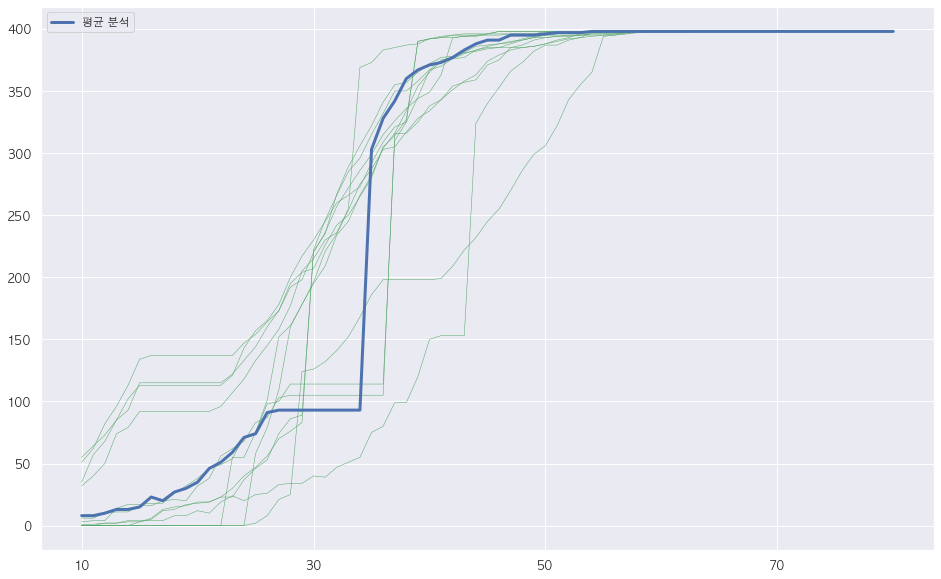

In [146]:
na = np.array(na_result['positive_count']['comp'])

plt.figure(figsize=(16,10))
for nor in na:
    plt.plot(range(min_per, max_per + 1),nor, linewidth=0.5, color='g')
    
me = np.array(mean_result[1]['positive_count']['comp'])
for mea in me:
    plt.plot(range(min_per, max_per + 1),mea, linewidth=3, color='b', label="평균 분석")
    
plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()

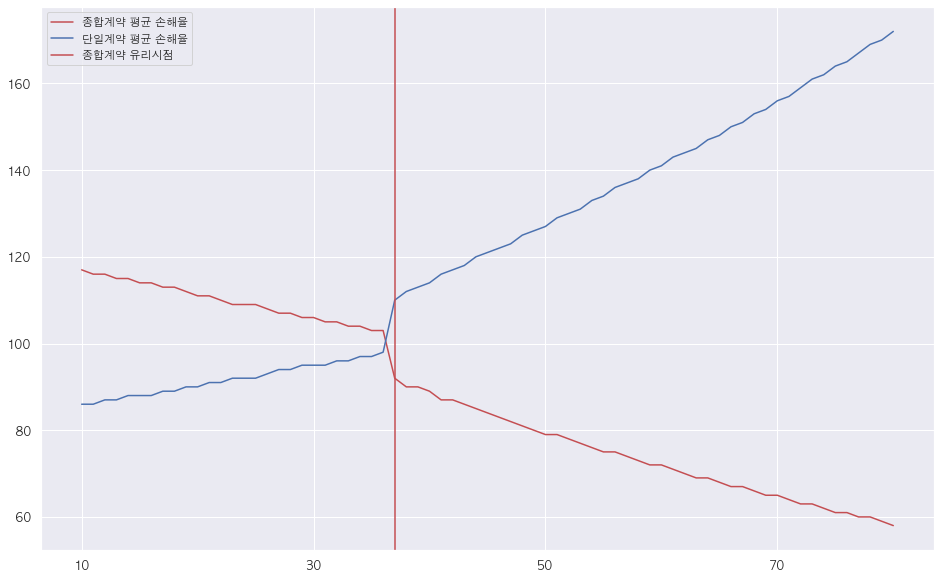

In [210]:
target = 'loss_ratio'

comp = np.array(anal_result[1][target]['comp'])[0]
single = np.array(anal_result[1][target]['single'])[0]


chk = anal_result[1]['pos_change_per'][target][0]

plt.figure(figsize=(16,10))
plt.plot(range(min_per, max_per + 1),comp, color='r',label="종합계약 평균 손해율")
plt.plot(range(min_per, max_per + 1),single, color='b', label="단일계약 평균 손해율")
plt.axvline(chk, color='r', label="종합계약 유리시점")

plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()

In [103]:
min_per

10

In [188]:
# 추천이 들어가는 곳
# 6. similarity_analysis
# 유사도 높은 패턴들을 기준으로 사용량을 재구성하여 일반분석 진행
anal_result = nu.similarity_analysis(m, p, min_per, max_per)

1 월 계산 진행 합니다.
가구 수: 398 / 평균: 255 / 표준편차: 87 / 변동계수: 34


In [202]:
anal_result[1]['loss_ratio']['comp']

,10,11,12,13,14,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
1,117.0,116.0,116.0,115.0,115.0,114.0,114.0,113.0,113.0,112.0,...,64.0,63.0,63.0,62.0,61.0,61.0,60.0,60.0,59.0,58.0


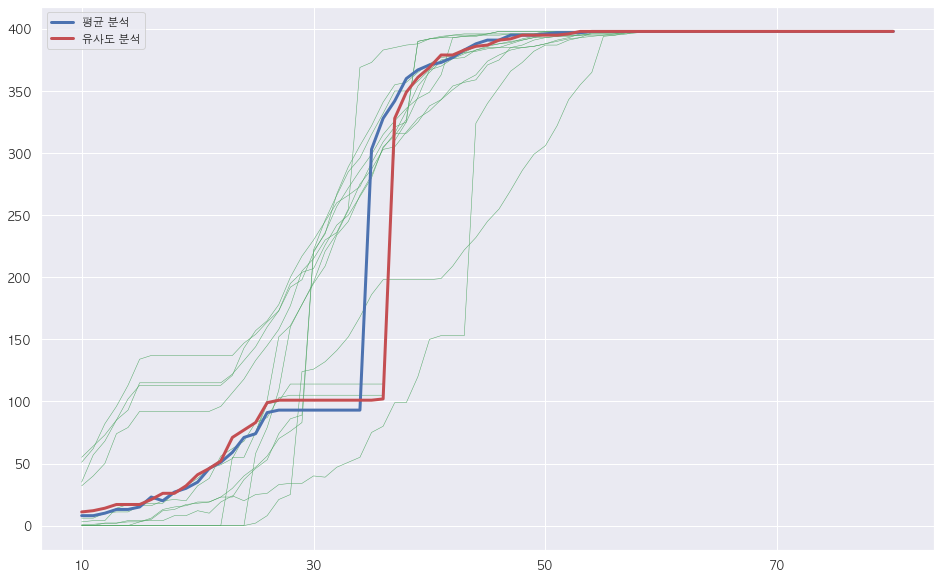

In [176]:
na = np.array(na_result['positive_count']['comp'])

plt.figure(figsize=(16,10))
for nor in na:
    plt.plot(range(min_per, max_per + 1),nor, linewidth=0.5, color='g')
    
me = np.array(mean_result[1]['positive_count']['comp'])
for mea in me:
    plt.plot(range(min_per, max_per + 1),mea, linewidth=3, color='b', label="평균 분석")
    
an = np.array(anal_result[1]['positive_count']['comp'])
for ana in an:
    plt.plot(range(min_per, max_per + 1),ana, linewidth=3, color='r', label="유사도 분석")
    
plt.xticks(range(min_per, max_per + 1, 20))
plt.legend()

In [178]:
a = m.set_index("month")
test = np.array(a)
r,c = test.shape
imp_weight = 0.99

recos = np.array([])

for t in trange(c - 1):
    if t == 0:
        dr_matrix = test
    else:
        dr_size = c - t
        svd = TruncatedSVD(n_components=dr_size)
        dr_matrix = svd.fit_transform(test)
    
    imp = np.array([])
    for A in dr_matrix:
        _ = np.array([])
        for B in dr_matrix:
            _ = np.append(_, improved_similarity(
                    A, B, imp_weight
                ))
        imp = np.append(imp, _)
        imp = imp.reshape(r, -1)
        
    reco_idx = imp.mean(axis=1).argmax()
    
    if ~np.any(recos == reco_idx):
        recos = np.append(recos, reco_idx)
   
mean_pattern = np.array(m.set_index("month").copy().mean(axis=0).round())
sim_pattern = np.array(m.set_index("month").iloc[recos].copy().mean(axis=0).round())

test = np.append(test, [mean_pattern], axis=0)
test = np.append(test, [sim_pattern], axis=0)

100%|████████████████████████████████████████| 397/397 [00:02<00:00, 191.17it/s]


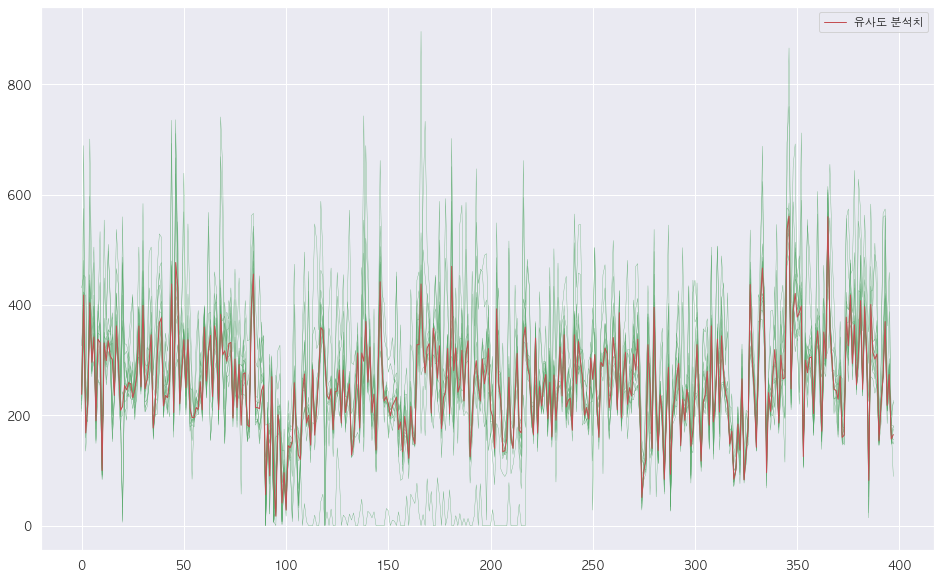

In [187]:
test = m.set_index("month")
test.loc['sim'] = sim_pattern
test

test_np = np.array(test)
plt.figure(figsize=(16,10))
for idx, value in enumerate(test_np):
    plt.plot(value, linewidth=0.3, color='g')
    if idx == 12:
        plt.plot(value, linewidth=1, color='r', label="유사도 분석치")

plt.legend()


In [173]:
recos

array([ 1.,  2.,  9., 10.])

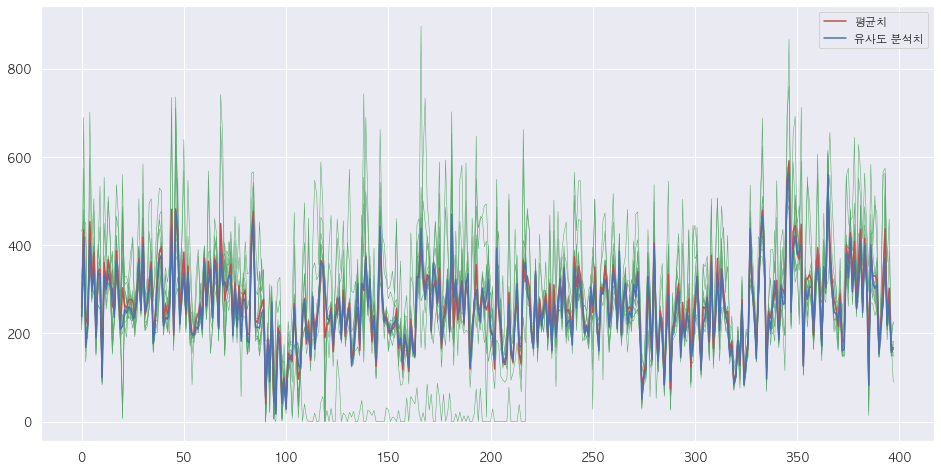

In [180]:
plt.figure(figsize=(16,8))
for idx,a in enumerate(test):
    
    
    if idx == 12:
        plt.plot(a, linewidth=1.5, color='r', label="평균치")
    elif idx == 13:
        plt.plot(a, linewidth=1.5, color='b', label="유사도 분석치")
    else:
        chk = np.where(recos == idx)
        plt.plot(a, linewidth=0.5, color='g')
        
plt.legend() 
plt.show()

In [184]:
analysis_df = pd.DataFrame(columns=["월","유클리디안 거리","코사인 유사도","피어슨 상관계수"])

for idx, A in enumerate(test):
    sim_chks = np.array([])
    for B in test:
        sim_chks = np.append(sim_chks, [
            nu.euclidean_distance(A, B),
            round(nu.cosine_similarity(A, B) * 1000),
            round(nu.corr(A, B) * 1000)
        ])
        
    euc, cos, corr = np.round(sim_chks.reshape(-1,3).mean(axis=0))
    if idx == 12:
        month = "평균치"
    elif idx == 13:
        month = "유사도 분석치"
    else:
        month = "{}".format(idx + 1)
        
    chk = np.where(recos == idx)
    is_reco = False
    if len(chk[0]) != 0:
        is_reco = True
    
    analysis_df = analysis_df.append(pd.Series({
        "월": month,
        "유클리디안 거리": euc,
        "코사인 유사도": cos,
        "피어슨 상관계수": corr
    }, name="{}".format(idx)))
    
analysis_df

,월,유클리디안 거리,코사인 유사도,피어슨 상관계수
0,1,1465.0,970.0,805.0
1,2,1273.0,974.0,824.0
2,3,1271.0,975.0,825.0
3,4,1304.0,974.0,819.0
4,5,2745.0,876.0,517.0
5,6,1570.0,969.0,777.0
6,7,2330.0,965.0,761.0
7,8,2545.0,959.0,728.0
8,9,1393.0,974.0,817.0
9,10,1282.0,975.0,833.0


In [183]:
m_np = np.array(m.set_index('month'))
sim_chk_df = pd.DataFrame(columns=['월','유클리디안 거리', '코사인 유사도', '향상된 유사도'])


# nu.euclidean_distance
# nu.cosine_similarity
for idx,A in enumerate(m_np):
    euc = np.array([])
    cos = np.array([])
    imp = np.array([])
    for B in m_np:
        euc = np.append(euc, nu.euclidean_distance(
            A,B
        ))
        cos = np.append(cos, nu.cosine_similarity(
            A,B
        ))
        imp = np.append(imp, nu.improved_similarity(
            A,B, 0.99
        ))
        
    chk = np.where(recos == idx)
    is_reco = False
    if len(chk[0]) != 0:
        is_reco = True
        
    month = idx + 1
    
    if idx == 12:
        month="mean"
    if idx == 13:
        month="sim"
        
    sim_chk_df = sim_chk_df.append({
        "월": month,
        "유클리디안 거리": euc.mean(),
        "코사인 유사도": cos.mean(),
        "향상된 유사도": imp.mean()
    },ignore_index=True)
    
sim_chk_df

,월,유클리디안 거리,코사인 유사도,향상된 유사도
0,1.0,1539.376025,0.967440,0.488647
1,2.0,1375.098336,0.970545,0.531869
2,3.0,1371.152572,0.971301,0.531375
3,4.0,1397.591343,0.970745,0.524707
4,5.0,2762.484023,0.875316,0.267866
5,6.0,1632.188900,0.967473,0.462109
6,7.0,2340.762432,0.963159,0.339475
7,8.0,2549.650267,0.956797,0.314890
8,9.0,1473.173231,0.970879,0.504920
9,10.0,1381.910319,0.972119,0.529319


In [165]:
sim_chk_df.sort_values(by=["유클리디안 거리"])

,유클리디안 거리,코사인 유사도,향상된 유사도
2,1371.152572,0.971301,0.531375
1,1375.098336,0.970545,0.531869
9,1381.910319,0.972119,0.529319
3,1397.591343,0.970745,0.524707
10,1416.384105,0.968969,0.519520
8,1473.173231,0.970879,0.504920
0,1539.376025,0.967440,0.488647
5,1632.188900,0.967473,0.462109
11,1637.833126,0.963393,0.465825
6,2340.762432,0.963159,0.339475


In [167]:
sim_chk_df.sort_values(by=["코사인 유사도"], ascending=False)

,유클리디안 거리,코사인 유사도,향상된 유사도
9,1381.910319,0.972119,0.529319
2,1371.152572,0.971301,0.531375
8,1473.173231,0.970879,0.504920
3,1397.591343,0.970745,0.524707
1,1375.098336,0.970545,0.531869
10,1416.384105,0.968969,0.519520
5,1632.188900,0.967473,0.462109
0,1539.376025,0.967440,0.488647
11,1637.833126,0.963393,0.465825
6,2340.762432,0.963159,0.339475


In [168]:
sim_chk_df.sort_values(by=["향상된 유사도"], ascending=False)

,유클리디안 거리,코사인 유사도,향상된 유사도
1,1375.098336,0.970545,0.531869
2,1371.152572,0.971301,0.531375
9,1381.910319,0.972119,0.529319
3,1397.591343,0.970745,0.524707
10,1416.384105,0.968969,0.519520
8,1473.173231,0.970879,0.504920
0,1539.376025,0.967440,0.488647
11,1637.833126,0.963393,0.465825
5,1632.188900,0.967473,0.462109
6,2340.762432,0.963159,0.339475
